In [2]:
# prepare 
import numpy as np
import pylab as pb
import GPy as gpy
import matplotlib
from matplotlib import pyplot as plt
from numpy.linalg import inv
from IPython.display import display
from scipy.fftpack import fft, ifft
pb.ion()
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)

In [70]:
# number of samples
n = np.arange(0,5,1)[np.newaxis].transpose() 

# time
fs = 5.0  #  time step:1/fs
t = np.arange(0,5,1/fs)[np.newaxis].transpose()
t.size

# number of cancer types
c = np.arange(0,6,1)[np.newaxis].transpose() 

In [72]:
# Given covariance matrix 
# Requirement: tr(sigma_N) = tr(sigma_T) = tr(sigma_C)

# sigma_N: covariance along N
k1 = gpy.kern.RBF(1, variance=2.0, lengthscale=1)
sigma_N = k1.K(n)
print np.matrix.trace(sigma_N)

# sigma_T: covariance along T
k2 = gpy.kern.RBF(1, variance=2.0 * n.size/t.size, lengthscale=2)
sigma_T = k2.K(t)
print np.matrix.trace(sigma_T)

# sigma_C: covariance along C
k3 = gpy.kern.RBF(1, variance=2.0 * n.size/c.size, lengthscale=1)
sigma_C = k3.K(c)
print np.matrix.trace(sigma_C)

10.0
10.0
10.0


In [73]:
# require tr(sigma_N) = tr(U) * tr(V) * tr(W) 
# U/tr(U) = sigma_N/tr(sigma_N)
# V/tr(V) = sigma_T/tr(sigma_T)
# W/tr(W) = sigma_C/tr(sigma_C)
U = sigma_N/np.matrix.trace(sigma_N) * np.matrix.trace(sigma_N)
V = sigma_T/np.matrix.trace(sigma_N) 
W = sigma_C/np.matrix.trace(sigma_N) 
print U
print V
print W

[[  2.00000000e+00   1.21306132e+00   2.70670566e-01   2.22179931e-02
    6.70925256e-04]
 [  1.21306132e+00   2.00000000e+00   1.21306132e+00   2.70670566e-01
    2.22179931e-02]
 [  2.70670566e-01   1.21306132e+00   2.00000000e+00   1.21306132e+00
    2.70670566e-01]
 [  2.22179931e-02   2.70670566e-01   1.21306132e+00   2.00000000e+00
    1.21306132e+00]
 [  6.70925256e-04   2.22179931e-02   2.70670566e-01   1.21306132e+00
    2.00000000e+00]]
[[ 0.04        0.0398005   0.03920795  0.0382399   0.03692465  0.03529988
   0.03341081  0.03130818  0.02904596  0.02667907  0.02426123  0.02184298
   0.01947009  0.01718229  0.01501244  0.0129861   0.01112149  0.00942984
   0.00791595  0.00657898  0.00541341  0.00441002  0.00355686  0.00284021
   0.00224539]
 [ 0.0398005   0.04        0.0398005   0.03920795  0.0382399   0.03692465
   0.03529988  0.03341081  0.03130818  0.02904596  0.02667907  0.02426123
   0.02184298  0.01947009  0.01718229  0.01501244  0.0129861   0.01112149
   0.00942984  0

In [74]:
# generate new data (1000 times) using U, V, W 
# calculate sample covariance along N, T, C to estimate sigma_N, sigma_T, sigma_C

x_N = 0 # estimate of sigma_N
x_T = 0 # estimate of sigma_T
x_C = 0 # estimate of sigma_C

for i in xrange(1, 1000):
    x = np.random.multivariate_normal(np.zeros(t.size*n.size*c.size), np.kron(W,np.kron(U.T,V.T)), 1)
    
    # reshape
    z = x.reshape(c.size,n.size,t.size)
    
    # cancer type (c), # of samples (n), time (t) 
    
    # covariance along cancer c
    nn = c.size
    a = np.empty((nn,nn))
    
    for i in range(nn):
        for j in range(nn):
            a[i,j] = (z[i,:,:] * z[j,:,:]).sum()
    x_C = x_C + a
   
    # covariance along number of samples n
    nn = n.size
    b = np.empty((nn,nn))
    
    for i in range(nn):
        for j in range(nn):
            b[i,j] = (z[:,i,:] * z[:,j,:]).sum()
    x_N = x_N + b
    
    # covariance along time (t)
    nn = t.size
    d = np.empty((nn,nn))
    
    for i in range(nn):
        for j in range(nn):
            d[i,j] = (z[:,:,i] * z[:,:,j]).sum()
    x_T = x_T + d
    
     
x_N = x_N/1000
x_T = x_T/1000
x_C = x_C/1000

 C:\Users\Ruoxi\Anaconda\lib\site-packages\IPython\kernel\__main__.py:9: RuntimeWarning:covariance is not positive-semidefinite.


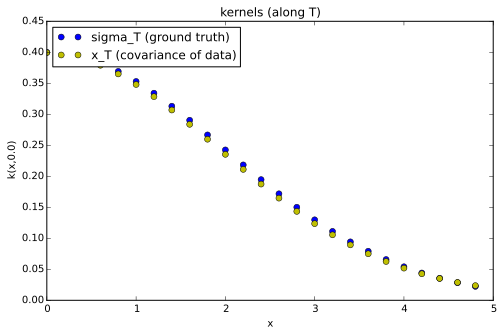

In [75]:
# plot covariance along T  axis (using kernels) and compared with ground truth
plt.plot(t, np.array(sigma_T[0,]).flatten(), 'bo')
_ = plt.plot(t, np.array(x_T[0,]).flatten(), 'yo')

plt.xlabel('x'); plt.ylabel('k(x,0.0)'); plt.title('kernels (along T)')
plt.legend(['sigma_T (ground truth)', 'x_T (covariance of data)'], loc='upper left')

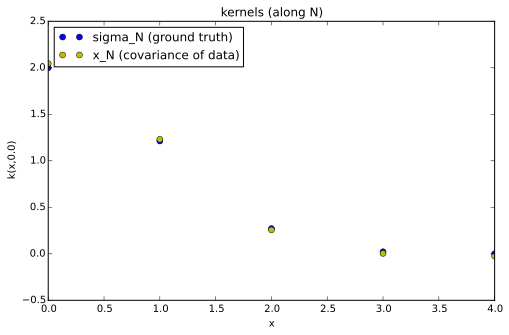

In [76]:
# plot covariance along N axis (using kernels) and compared with ground truth
plt.plot(n, np.array(sigma_N[0,]).flatten(), 'bo')
_ = plt.plot(n, np.array(x_N[0,]).flatten(), 'yo')
plt.xlabel('x'); plt.ylabel('k(x,0.0)'); plt.title('kernels (along N)')
plt.legend(['sigma_N (ground truth)', 'x_N (covariance of data)'], loc='upper left')

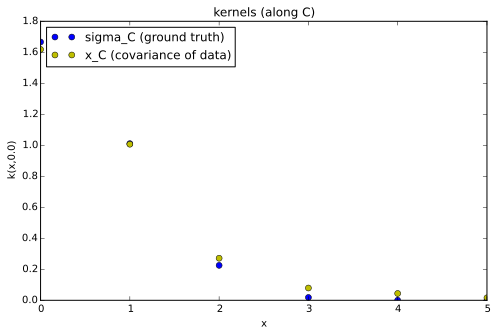

In [77]:
# plot covariance along C axis (using kernels) and compared with ground truth
plt.plot(c, np.array(sigma_C[0,]).flatten(), 'bo')
_ = plt.plot(c, np.array(x_C[0,]).flatten(), 'yo')
plt.xlabel('x'); plt.ylabel('k(x,0.0)'); plt.title('kernels (along C)')
plt.legend(['sigma_C (ground truth)', 'x_C (covariance of data)'], loc='upper left')